In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from src.const import AUDIO_PATH, MAIN_LABELS, BATCH_SIZE, VALIDATION_SPLIT, SEED
from src.data_loader import load_data

In [3]:
train_ds, val_ds = load_data()

Found 64721 files belonging to 11 classes.
Using 51777 files for training.
Using 12944 files for validation.


2024-04-13 18:22:09.013849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 18:22:09.014121: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
main_file_count = 0
unknown_file_count = 0
for class_dir in os.listdir(AUDIO_PATH):
    for file in os.listdir(os.path.join(AUDIO_PATH, class_dir)):
        if class_dir in MAIN_LABELS:
            main_file_count += 1
        else:
            unknown_file_count +=1

print(f"Main files count: {main_file_count}")
print(f"Unknown files count: {unknown_file_count}")

Main files count: 23682
Unknown files count: 41039


In [5]:
label_names = np.array(train_ds.class_names)
print("label names:", label_names)


label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10']


In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


2024-04-13 18:37:25.887931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


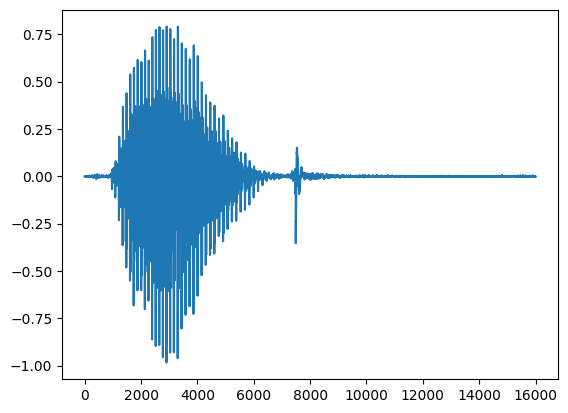

In [43]:
for X, y in train_ds.take(1):
    plt.plot(np.arange(0, len(X[0])), X[0].numpy())

In [1]:
def single_shift(inputs):
    shift_size = int(np.clip(np.random.normal(5000, 3000), 0, 12000))
    print(shift_size)
    direction = np.random.choice([0, 1])
    if direction:
        shifted = tf.concat( (inputs[:, shift_size:], tf.zeros([tf.shape(inputs)[0], shift_size]) ), axis=1)
    else:
        shifted = tf.concat( (tf.zeros([tf.shape(inputs)[0], shift_size]), inputs[:16000-shift_size] ), axis=1)
    return shifted

def shift(inputs):
    shifted = tf.map_fn(lambda x: single_shift(x), inputs, dtype=tf.float32)
    return shifted


train_ds_shifted_left = train_ds.map(
    map_func = lambda audio, label: (shift(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds_shifted_right = train_ds.map(
    map_func = lambda audio, label: (shift(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

SyntaxError: invalid syntax (2650845409.py, line 6)

2024-04-13 20:08:34.527513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


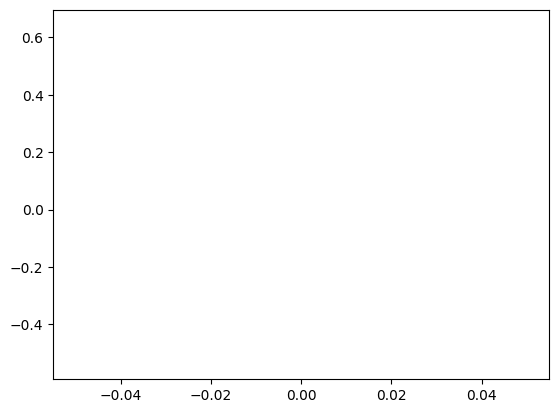

In [248]:
for X, y in train_ds_shifted_left.take(1):
    plt.plot(np.arange(0, len(X[0])), X[0].numpy())

In [213]:
combined_ds = train_ds.concatenate(train_ds_aug)
combined_ds

<tf.Tensor: shape=(), dtype=int64, numpy=810>

In [9]:
def preprocess_data_into_specs(ds):

  nfft=512
  window=512
  stride=256
  rate=16000
  mels=128
  fmin=0 
  fmax=8000
  top_db=80

  spect_ds = ds.map(
      map_func=lambda audio,label: (tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=stride), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  mel_spect_ds = spect_ds.map(
    map_func=lambda audio, label: (tfio.audio.melscale(audio, rate=rate, mels=mels, fmin=fmin, fmax=fmax), label),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  return mel_spect_ds.map(
      map_func=lambda audio,label: (tfio.audio.dbscale(audio, top_db=top_db), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
spec_train_ds = preprocess_data_into_specs(train_ds)
spec_val_ds = preprocess_data_into_specs(val_ds)

In [ ]:
for example_spec_audio, example_spec_labels in spec_train_ds.take(10):
    print(example_spec_audio.shape)

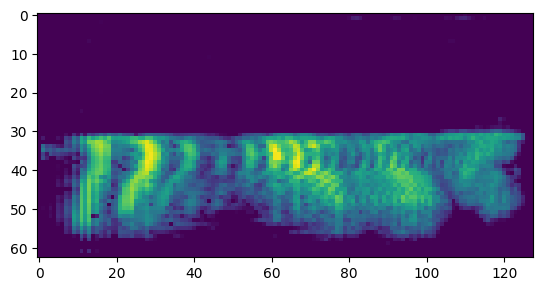

In [15]:
plt.imshow(example_spec_audio[39].numpy())
plt.show()

In [28]:
input_shape=(63,128)
model = tf.keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(11, activation='softmax'))
model.summary()

# layers.Bidirectional(layers.LSTM(20), merge_mode="sum")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,283 (555.79 KB)

 Trainable params: 142,283 (555.79 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
train_spectrogram_ds = spec_train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = spec_val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_spectrogram_ds, epochs=50, validation_data=val_spectrogram_ds)